## Import Libraries

In [141]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

In [142]:
print(pd.__version__)

2.2.2


## Load the Data

In [143]:
df = pd.read_csv("../Datasets/Higher player.csv")

In [144]:
df.dtypes

Unnamed: 0               int64
team                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
dtype: object

In [145]:
df.head(2)

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,0,Manchester United,Goalkeeper,189.0,32.0,104,0.00000,0.00000,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000
1,3,Manchester United,Defender Centre-Back,175.0,25.0,82,0.02809,0.05618,0.224719,0.0,0.0,0.000000,0.000000,6408,175,22,9,50000000,50000000


In [146]:
df.drop(columns='Unnamed: 0' , inplace = True)

## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [147]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value


In [148]:
# Completeness
df.isnull().sum()

team                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
dtype: int64

In [149]:
numeric_col = [col for col in df.columns if df[col].dtype != "object"]
categorical_col = [col for col in df.columns if df[col].dtype == "object"]

In [150]:
# for i in categorical_col:
#     print(df[i].value_counts())

In [151]:
# Calculate the 35th and 75th percentiles of the price
p35 = df['current_value'].quantile(0.35)
p75 = df['current_value'].quantile(0.75)

# Function to categorize prices
def categorize_price(price):
    if price < p35:
        return 'Cheap_Price'
    elif price < p75:
        return 'Good_Price'
    else:
        return 'High_Price'

# Apply the function to create a new column
df['sale_price_category'] = df['current_value'].apply(categorize_price)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['sale_price_category'].value_counts())

sale_price_category
Good_Price     2017
Cheap_Price    1603
High_Price     1220
Name: count, dtype: int64


In [152]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,highest_value,sale_price_category
0,Manchester United,Goalkeeper,189.0,32.0,104,0.00000,0.00000,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,70000000,High_Price
1,Manchester United,Defender Centre-Back,175.0,25.0,82,0.02809,0.05618,0.224719,0.0,0.0,0.000000,0.000000,6408,175,22,9,50000000,High_Price


#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [153]:
categorical_col = ['team' , 'position']

In [154]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_col)

In [155]:
df.shape

(4840, 367)

In [156]:
encoder = LabelEncoder()
df['sale_price_category'] = encoder.fit_transform(df['sale_price_category'])

#### 3. Feature selection

In [157]:
correlation = df.corr()
correlation['sale_price_category'].sort_values(ascending=False)

sale_price_category    1.000000
highest_value          0.582366
appearance             0.494350
minutes played         0.378611
assists                0.238781
                         ...   
team_SV Ried          -0.083769
clean sheets          -0.092218
position_Goalkeeper   -0.113328
goals conceded        -0.121615
age                   -0.137774
Name: sale_price_category, Length: 367, dtype: float64

In [158]:
# Set the correlation threshold
threshold = 0.4  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['sale_price_category']) > threshold]['sale_price_category'].index
selected_features

Index(['appearance', 'highest_value', 'sale_price_category'], dtype='object')

In [159]:
df = df[selected_features]

#### 4. Prepare train and test data

In [160]:
# Prepare data
X = df.drop(['sale_price_category'], axis=1)
y = df['sale_price_category']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

StandardScaler()

In [161]:
X.shape

(4840, 2)

In [163]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Buliding the Model

In [164]:
model = LogisticRegression()

## Train the Model

In [165]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LogisticRegression()

## Test the Model

In [166]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Interpretation of the Model

In [167]:
model.coef_

array([[-0.62970249, -6.35615744],
       [ 0.01386588,  1.76505861],
       [ 0.6158366 ,  4.59109882]])

In [168]:
print(model.intercept_) 

[-2.22922157  1.64061271  0.58860886]


## Evaluating the Model 

In [169]:
# our benchmark model
base_model = round(df['sale_price_category'].value_counts()[1]/df.shape[0]*100, 2)
base_model

np.float64(41.67)

1. Accuracy

In [170]:
# Evaluate the model
accuracy_test = accuracy_score(y_test, y_pred)
print('Test Accuracy' ,accuracy_test*100)

y_pred_train = model.predict(X_train_scaled)
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Train Accuracy' ,accuracy_train*100)

Test Accuracy 75.72314049586777
Train Accuracy 73.86363636363636


2. Precision

In [171]:
# Calculate Precision
precision_test = precision_score(y_test, y_pred, average='macro')
print("Test Precision:" ,precision_test*100)

y_pred_train = model.predict(X_train_scaled)
precision_train = precision_score(y_train, y_pred_train, average='macro')
print('Train Precision:' ,precision_train*100)

Test Precision: 77.57072817237604
Train Precision: 75.57080010418774


3. Recall

In [172]:
# Calculate Recall
recall_test = recall_score(y_test, y_pred, average='macro')
print("Test Recall:" , recall_test*100)

y_pred_train = model.predict(X_train_scaled)
recall_train = precision_score(y_train, y_pred_train, average='macro')
print('Train Recall:' ,recall_train*100)

Test Recall: 76.14850427350427
Train Recall: 75.57080010418774


4. F1 Score

In [173]:
# Calculate F1 Score
f1_test = f1_score(y_test, y_pred, average='macro')
print("Test F1 Score:" , f1_test*100)

y_pred_train = model.predict(X_train_scaled)
f1_train = f1_score(y_train, y_pred_train, average='macro')
print('Train Recall:' ,f1_train*100)

Test F1 Score: 76.34453472882909
Train Recall: 74.32742810264492


#### Predictions vs. Real Values

In [174]:
predictions = model.predict(X_test_scaled)

In [175]:
Real_Values = np.array(y_test)
#Real_Values

#### Residual Histogram

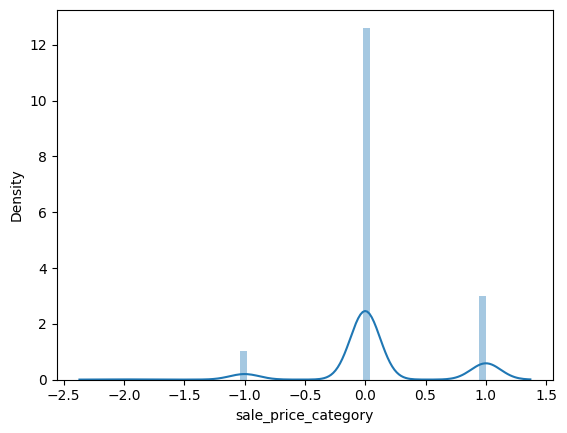

In [176]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution

In [177]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[274,  36,   2],
       [102, 275,  23],
       [  0,  72, 184]])

In [178]:
import joblib 

In [179]:
joblib.dump(model, 'reg.joblib')
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']